In [1]:
from data.transport import convection_diffusion
from modules.data import simulate_transport
from modules.plots import plot_training_loss
from modules.utils import PrintLossCallback
from modules.models import TransportEquation, create_dense_model
import matplotlib.pyplot as plt
import tensorflow as tf

2023-04-29 18:07:45.929973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 18:07:45.962067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 18:07:46.433084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(tx_samples, u_samples, samples_residuals), (tx_init, u_init), (tx_bnd_start, tx_bnd_end, u_boundary), (X, T, U) = simulate_transport(
    500, 200, 200, convection_diffusion, 30.0, time_steps=200, x_steps=256
)

2023-04-29 18:07:47.277461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 18:07:47.298281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 18:07:47.298433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

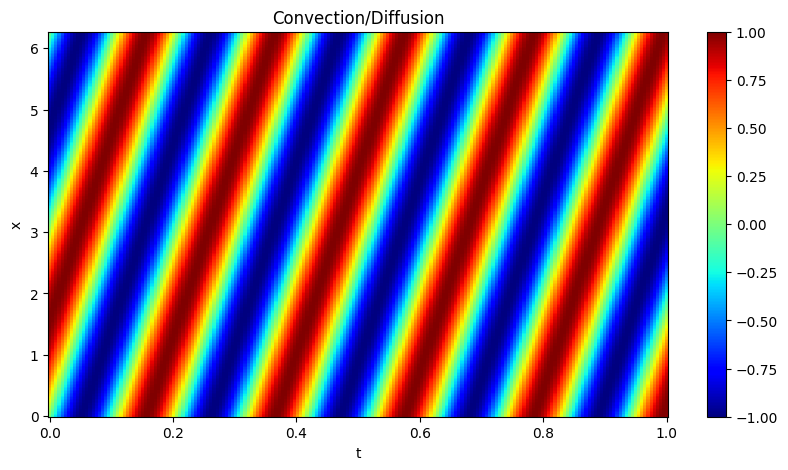

In [3]:
#plot meshgrid
plt.figure(figsize=(10, 5))
plt.pcolormesh(T, X, U, cmap='jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Convection/Diffusion')
plt.show()


In [4]:
inputs = [tx_samples, tx_init, tx_bnd_start, tx_bnd_end]
outputs = [u_samples, samples_residuals, u_init]

In [5]:
backbone = create_dense_model([1000, 1000], 'tanh', 'glorot_normal', 2, 1)
model = TransportEquation(backbone, 30.0)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 1000, 0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer)
hist = model.fit_custom(inputs, outputs, epochs=50000, print_every=1000)

2023-04-29 18:07:49.182458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-29 18:07:49.184710: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8bf88aacf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-29 18:07:49.184724: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-04-29 18:07:49.188079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-29 18:07:49.298953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-29 18:07:49.373997: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

Epoch 0, Loss Residual: 8.4906, Loss Initial: 0.4275, Loss Boundary: 0.3789, MAE: 0.6915
Epoch 1000, Loss Residual: 0.0017, Loss Initial: 0.4629, Loss Boundary: 0.0104, MAE: 0.6642
Epoch 2000, Loss Residual: 0.0033, Loss Initial: 0.4470, Loss Boundary: 0.0211, MAE: 0.6855
Epoch 3000, Loss Residual: 0.0037, Loss Initial: 0.4437, Loss Boundary: 0.0217, MAE: 0.6872
Epoch 4000, Loss Residual: 0.0280, Loss Initial: 0.4332, Loss Boundary: 0.0236, MAE: 0.6725
Epoch 5000, Loss Residual: 0.0073, Loss Initial: 0.3840, Loss Boundary: 0.0310, MAE: 0.7059
Epoch 6000, Loss Residual: 0.0024, Loss Initial: 0.2093, Loss Boundary: 0.0602, MAE: 0.6586
Epoch 7000, Loss Residual: 0.0039, Loss Initial: 0.0843, Loss Boundary: 0.0598, MAE: 0.6265
Epoch 8000, Loss Residual: 0.0027, Loss Initial: 0.0437, Loss Boundary: 0.0587, MAE: 0.6100
Epoch 9000, Loss Residual: 0.0031, Loss Initial: 0.0199, Loss Boundary: 0.0590, MAE: 0.6018
Epoch 10000, Loss Residual: 0.0020, Loss Initial: 0.0083, Loss Boundary: 0.0458, MA

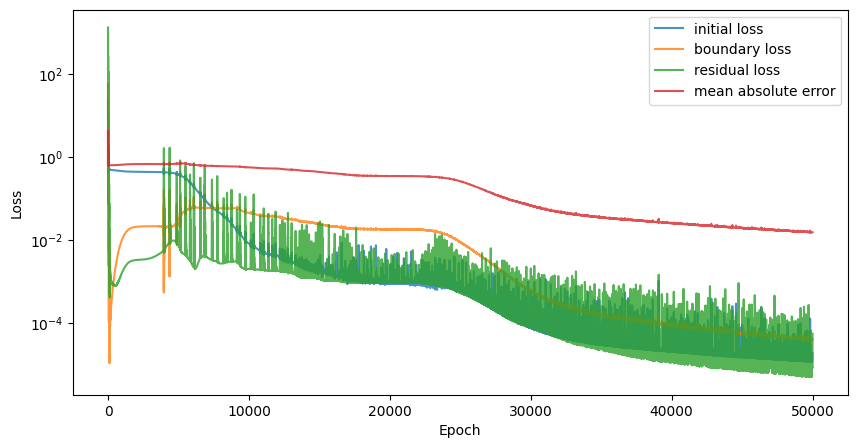

In [6]:
plot_training_loss(hist, y_scale='log')

1600/1600 [==============================] - 1s 481us/step


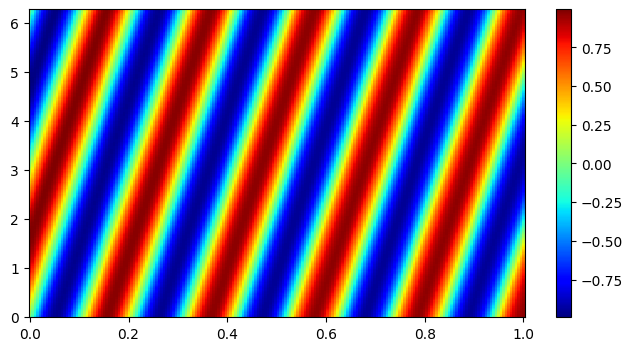

In [7]:
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape), cmap='jet')
plt.colorbar()